In [62]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.colors import SymLogNorm
import scienceplots

import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits,ascii
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats,sigma_clip
import astropy.visualization as vis
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel
from astropy.cosmology import Planck18,FlatLambdaCDM
from scipy.signal import find_peaks
#from scipy.constants import c


from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import estimate_line_parameters,fit_lines,find_lines_threshold
from specutils.manipulation import extract_region

from photutils.aperture import EllipticalAperture, SkyEllipticalAperture

import os, sys, glob, pdb, scipy

from importlib import reload
from spectral_cube import SpectralCube
from reproject import reproject_interp
import regions
from regions.shapes.circle import CircleSkyRegion,CirclePixelRegion
from regions import CircleAnnulusSkyRegion, CircleAnnulusPixelRegion, RectangleSkyRegion,RectanglePixelRegion
from regions import PixCoord
sys.path.append('/disk/bifrost/yuanze/KBSS/CubEx_run/scripts')
import run_cubetools_v1 as ctools
#mycosmos=FlatLambdaCDM(H0=70, Om0=0.3)
brightu = r"Brightness $\rm (10^{-4}~erg~s^{-1}~arcsec^{-2}~cm^{-2}~\AA^{-1})$"
def imshow_astro(img, wcsinfo = None, figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None)):
    
    _, med, std = sigma_clipped_stats(img.data)
    
    fig =  plt.figure(figsize = figsize)
    if wcsinfo:
        ax = plt.subplot(projection = wcsinfo)
    else:
        ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 10*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, norm = norm, cmap = cmap)
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    return fig, ax, im
KBSSpath="/disk/bifrost/yuanze/KBSS"

In [3]:
ld=Planck18.luminosity_distance(2.65).to(u.cm).value
print(4*np.pi*ld**2*1e-17)

6.007871259603367e+41


## Extract Lya luminosity

In [425]:
Lya_3arc={}
Lya_v={}
Lya_SB={}
Lya_sigma={}
line_total_flux={}
source_table = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN_KCWIobserved_MBH.list",format="ipac")
filters = ["table['KCWI'] == 'yes'","table['Name'] != 'FSzP1170'","table['Name'] != 'Lab5'"]
dtype="KBSS"
all_directories,tab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"))
#tid=["Q0100-BX160"]

#id_all=qsos["Name"]

# radius bin
#rbin=np.logspace(-0.5,0.48,num=6)
rbin=np.arange(0.3,6.3,0.3)
# windowsize to extract the Lya nebulae
windowsize=6*u.arcsec
#idall=
nondet_list=[]
for nq,sentry in enumerate(tab):
    sourcename=sentry["Name"]#re.findall(r"-(.*)",id)[0]
    csourcename=sentry["CName"]
    Qtype=sentry["Type"]
    field=sentry["Field"]#re.findall(r"(.*)-",id)[0]
    fullname=field+"-"+sourcename
    #sentry=qsos[qsos["Name"]==sourcename]
    #cubename=sentry["Cube"].value[0]
    #ext=sentry["ext"].value[0]
    subdapath=all_directories[nq]#KBSSpath+"/"+field+"/"+sourcename
    datapath=all_data_dir[nq]
    
    if Qtype < 2:
        Subfile = subdapath+"/{}-{}_icubes.PSFCONTSub.fits".format(field,sourcename)
        maskfn=subdapath+"/{}-{}_icubes.PSFSub.mask.fits".format(field,sourcename)
    else:
        Subfile = subdapath+"/{}-{}_icubes.CONTSub.fits".format(field,sourcename)
        maskfn=subdapath+"/{}-{}_icubes.CONTSub.mask.fits".format(field,sourcename)
    varfile=datapath+"/{}-{}_vcubes.fits".format(field,csourcename)
    
    try:
        O_cube = SpectralCube.read(Subfile)
        OV_cube = SpectralCube.read(varfile)
    except:
        print("file not found, skipping",field,sourcename)
        continue
    wcsinfo = O_cube.wcs.celestial
    RA = sentry["RA"]
    Dec = sentry["Decl"]
#    if sentry["zneb"]>0:
#        redshift=sentry["zneb"]
#    elif sentry["zabs"]>0:
#        redshift=sentry["zabs"]
#    else:
    redshift=sentry["zlya"]
    #redshift=sentry["z_Lyaneb"]
    #sc=SkyCoord(ra=RA, dec=Dec, unit='deg',frame="icrs", equinox='J2000')
    pixel_scale=wcsinfo.pixel_scale_matrix[1,1] * 3600

        
    sregion_pix=regions.RectanglePixelRegion(PixCoord(x=sentry['x'],y=sentry['y']),width=windowsize.value/pixel_scale,height=windowsize.value/pixel_scale)
    #sregion=regions.RectangleSkyRegion(sc,width=windowsize, height=windowsize)
    #sregion_pix=sregion.to_pixel(wcsinfo)

    #Sub_cube=O_cube.subcube_from_regions([sregion_pix])
    #Var_cube=OV_cube.subcube_from_regions([sregion_pix])
    
    #wcssub=Sub_cube.wcs.celestial
    
    specwidth=1
    cw=1215.67*(1+redshift) * u.AA
    #Lya_varcube = Var_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    Lya_subvarcube = OV_cube.spectral_slab(cw-10*u.AA,cw+14*u.AA)
    #Lya_cube = Sub_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    Lya_subcube = O_cube.spectral_slab(cw-10*u.AA,cw+14*u.AA)
#    Lya_subcube_wav = Lya_subcube.with_spectral_unit(u.AA, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    
    #Lya_moment_1 = Lya_subcube.moment(order=1)
    #Lya_linewid = Lya_subcube.linewidth_sigma()
    
    #Lya_msig = np.sqrt(Lya_subvarcube.sum(axis=0,how='cube'))
    #Lya_mflux = (Lya_subcube*specwidth).sum(axis=0,how='cube')

    #mask=Lya_mflux.value > 1.0*Lya_msig.value
    #bad=np.isnan(Lya_moment_1[mask])
    #Lya_SB[fullname]=Lya_mflux[mask].mean().value*100
    #flux weighted bulk velocity
    #bad=np.isnan(Lya_moment_1[mask])
    #Lya_v[sourcename]=(Lya_moment_1*Lya_mflux)[mask][~bad].sum()/Lya_mflux[mask][~bad].sum()
#    Lya_v[sourcename+"_err"]=np.sqrt((Lya_moment_1*Lya_mflux)[mask][~bad].var())/Lya_mflux[mask][~bad].sum()
    #flux weighted velocity dispersion
    #bad=np.isnan(Lya_linewid[mask])
    #Lya_sigma[sourcename]=(Lya_linewid*Lya_mflux)[mask][~bad].sum()/Lya_mflux[mask][~bad].sum()
#    Lya_sigma[sourcename+"_err"]=np.sqrt((Lya_linewid*Lya_mflux)[mask][~bad].var())/Lya_mflux[mask][~bad].sum()



    # Lya brightness within 3 arcsec
    #region_sky = CircleSkyRegion(center=sc, radius=3 * u.arcsec)
    #region_pix = region_sky.to_pixel(wcssub)
    contmask=fits.open(maskfn)[0].data
    region_pix = CircleAnnulusPixelRegion(PixCoord(x=sentry['x'],y=sentry['y']),0.6/pixel_scale,3/pixel_scale)#CirclePixelRegion(PixCoord(x=sentry['x'],y=sentry['y']), radius=3/pixel_scale)
    camask=region_pix.to_mask()
    camask2D_image = camask.to_image(Lya_subcube.shape[1:])
    mask_2d_filtered=camask2D_image.astype(bool) & (~contmask.astype(bool)) #what if we take the circular-annulus region rather than the CubEx detected region,np.nansum(mask_3d_filtered,axis=0)
    expanded_mask = np.repeat(mask_2d_filtered[np.newaxis, :, :], Lya_subcube.shape[0], axis=0)
    
    
    Lya_mflux_sub=np.nansum(np.where(expanded_mask.astype(bool), Lya_subcube.unmasked_data[:].value, 0),axis=0)
    Lya_mvar_sub=np.nansum(np.where(expanded_mask.astype(bool), Lya_subvarcube.unmasked_data[:].value, 0),axis=0)
    
    #npix=np.sum((~np.isnan(Lya_mflux_sub)).astype(int))
    Lya_3arc[fullname]=[pixel_scale**2*np.nansum(Lya_mflux_sub),pixel_scale**2*np.sqrt(np.nansum(Lya_mvar_sub))]
    
    
    ### method 2 =================================================
    Checkcube=fits.open(subdapath+"/{}-{}_icubes.PSFCONTSub.Objects_Id_Lya.fits".format(field,sourcename))
    objcat=np.genfromtxt(subdapath+"/{}-{}_Lya.cat".format(field,sourcename))
    mask_3d=Checkcube[0].data
    
    # wavelength range for the extraction cube
    lw=Checkcube[0].header["CRVAL3"]
    hw=Checkcube[0].header["CRVAL3"]+(mask_3d.shape[0]-1)*Checkcube[0].header["CD3_3"]
    
    #Cut-off: geometric center of the detected object must be within N pixels of the PSF center (1 pix \simeq 0.3 arcsec)
    Npix=10
    if field == "Q2233" and sourcename == "D5":
        Npix=15
    print("Using distance limit (pix):",Npix)
    s_coord=np.array([sentry['x'],sentry['y']])
    nondet=False
    if len(objcat.shape)>1:
        obj_coord=objcat[:,2:4]
        obj_num=objcat[:,0]
        dis=np.linalg.norm(obj_coord - np.array(s_coord),axis=1)
        print("distance from PSF to objects (pixels):")
        print(dis)
        sel_num=obj_num[dis<Npix]
        print("selected objects: obj_num, N_Voxels")
        print(sel_num,objcat[:,1][dis<Npix])
        if sel_num.size == 0:
            nondet=True
    else:
        obj_coord=objcat[2:4]
        obj_num=objcat[0]
        dis=np.linalg.norm(obj_coord - np.array(s_coord))
        print("distance from PSF to objects (pixels):")
        print(dis)
        if dis < Npix:
            sel_num=obj_num
            print("selected objects: obj_num, N_Voxels")
            print(sel_num,objcat[1])
        else:
            nondet=True
    nondet_list.append(nondet)
    #sel_num=np.array([4])
    #if nondet:
        #region_pixgen = CirclePixelRegion(center=PixCoord(x=sentry['x'],y=sentry['y']),radius=2)
        #mask_3d_filtered = region_pixgen
    mask_3d_filtered=np.isin(mask_3d, sel_num.astype(int))

    region_pix4 = CirclePixelRegion(center=PixCoord(x=sentry['x'],y=sentry['y']),radius=2)
    rmask=region_pix4.to_mask()
    rmask2D_image = rmask.to_image(mask_3d_filtered.shape[1:])
    expanded_rmask_image = np.repeat(rmask2D_image[np.newaxis, :, :], mask_3d_filtered.shape[0], axis=0)
    # Excluding the central 1 pixel radius
    mask_3d_filtered=mask_3d_filtered & (~expanded_rmask_image.astype(bool))

    mask_2d_filtered=np.nansum(mask_3d_filtered,axis=0)
    ##recast the 2D to 3D, but selecting everything on spectral axis
    expanded_mask_2d = np.repeat(mask_2d_filtered[np.newaxis, :, :], mask_3d_filtered.shape[0], axis=0)
    
    subcube1=O_cube.spectral_slab(lw*u.AA,hw*u.AA)
    varsubcube1=OV_cube.spectral_slab(lw*u.AA,hw*u.AA)
    subcube2=subcube1.unmasked_data[:].value
    varsubcube2=varsubcube1.unmasked_data[:].value
    #line_maskedcube = np.where(mask_3d_filtered.astype(bool), subcube2, 0)
    #line_maskedcube_var = np.where(mask_3d_filtered.astype(bool), varsubcube2, 0)
    line_maskedcube = np.where(mask_3d_filtered.astype(bool), subcube2, np.nan)
    line_maskedcube_var = np.where(mask_3d_filtered.astype(bool), varsubcube2, np.nan)

    
    if nondet:
        line_maskedcube_var = np.where(expanded_rmask_image.astype(bool), varsubcube2, np.nan)
        line_maskedcube = 2*line_maskedcube_var
    else:
        line_maskedcube = np.where(mask_3d_filtered.astype(bool), subcube2, np.nan)
        line_maskedcube_var = np.where(mask_3d_filtered.astype(bool), varsubcube2, np.nan)
    line_mflux=np.nansum(line_maskedcube,axis=0)
    line_mflux_var=np.nansum(line_maskedcube_var,axis=0)
    tflux_val, tflux_sig=np.nansum(line_mflux*pixel_scale**2,axis=(0,1)),np.sqrt(np.nansum(line_mflux_var,axis=(0,1)))*pixel_scale**2
    line_total_flux[fullname]=[tflux_val, tflux_sig]
        
    print("SNR:",line_total_flux[fullname][0]/line_total_flux[fullname][1])
    print(field,sourcename,"Done")
    print("-----------------------------------------")
    # Log scaled radius SB profile
    """
    Aregions=[]
    Aregions_value=[]
    Aregions_sigvalue=[]
    for rind, rin in enumerate(rbin):
        if rind<len(rbin)-1:
            region_annulus_sky = CircleAnnulusSkyRegion(center=sc,
                                                inner_radius=rin * u.arcsec,
                                                outer_radius=rbin[rind+1] * u.arcsec)
            region_annulus_pix = region_annulus_sky.to_pixel(wcssub)
            Aregions.append(region_annulus_pix)
            Lya_mflux_sub=Lya_subcube.subcube_from_regions([region_annulus_pix]).sum(axis=0,how='cube')
            Lya_mvar_sub=Lya_subvarcube.subcube_from_regions([region_annulus_pix]).sum(axis=0,how='cube')
            Aregions_value.append((np.nansum(Lya_mflux_sub/Lya_mvar_sub)/np.nansum(1/Lya_mvar_sub)).value)
            Aregions_sigvalue.append(np.sqrt(1/np.nansum(1/Lya_mvar_sub)).value)
        else:
            continue
    annulus_bin[sourcename]=Aregions
    annulus_value[sourcename]=[Aregions_value,Aregions_sigvalue]
    """
#    mask_annulus_reg = region_annulus_pix.to_mask()
#    mask_annulus_reg = mask_annulus_reg.to_image(Sub_cube.shape[1:]).astype(bool)







Using distance limit (pix): 10
distance from PSF to objects (pixels):
[33.17717589 12.94345394]
selected objects: obj_num, N_Voxels
[] []
SNR: 0.1773358412984307
Q0100 BX160 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[33.71682666 53.24648345 18.58641708]
selected objects: obj_num, N_Voxels
[] []
SNR: 0.16858054452152416
Q0100 BX164 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[52.45547159 29.36158715  3.18449368 46.46178645]
selected objects: obj_num, N_Voxels
[3.] [7621.]
SNR: 297.34137508407576
Q0100 BX172 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
0.8215229759416371
selected objects: obj_num, N_Voxels
1.0 410.0
SNR: 28.948414823316558
Q0105 BX58 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
0.4341658669218474
selected objects: obj_num, N_Voxels
1.0 2914.0
SNR: 158.54317751629847
Q0142 BX195 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
1.2728707711311447
selected objects: obj_num, N_Voxels
1.0 2142.0
SNR: 120.16235161180343
Q0207 BX298 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
13.875968434671506
SNR: 0.1504019043743334
Q0207 D9 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[27.7640631   2.21350401 27.64598524]
selected objects: obj_num, N_Voxels
[2.] [139.]
SNR: 15.198177579262838
Q0256 c31 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[4.20373643 8.01491734]
selected objects: obj_num, N_Voxels
[1. 2.] [ 498. 2065.]
SNR: 91.47863581778019
Q0821 RK5 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[ 1.60181147 19.04863512]
selected objects: obj_num, N_Voxels
[1.] [3086.]
SNR: 139.27350833041595
Q0821 D8 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[29.50635355  1.62409975 29.67574936  9.78587758 29.62985825]
selected objects: obj_num, N_Voxels
[2. 4.] [ 693. 2716.]
SNR: 88.94075547860882
Q1549 BX101 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
3.9721153054764176
selected objects: obj_num, N_Voxels
1.0 7454.0
SNR: 215.00278090203165
Q1549 GNB4950 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[1.23722674e+01 6.08674790e+00 6.47416999e+01 2.87845862e+01
 6.32455532e-02 3.84524967e+01 1.23403079e+01 2.97746822e+01
 3.91701034e+01]
selected objects: obj_num, N_Voxels
[2. 5.] [152. 865.]
SNR: 40.321670435059076
Q1549 M15 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[17.83250964 15.22047305 66.77097049 30.42130997 11.86551305 42.38313934
  5.45770098 28.75589157 33.22832075 41.09974696]
selected objects: obj_num, N_Voxels
[7.] [84.]
SNR: 11.994114284035943
Q1549 MD10 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[25.31605419 43.1434688 ]
selected objects: obj_num, N_Voxels
[] []
SNR: 0.34850321256280214
Q1549 MD17 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
3.916184367467905
selected objects: obj_num, N_Voxels
1.0 606.0
SNR: 41.02414540786592
Q1549 MD28 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[18.51841516  1.74645355 22.34676934]
selected objects: obj_num, N_Voxels
[2.] [665.]
SNR: 43.51504992421423
Q1603 BX191 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[ 1.82989071 39.18957132 40.58076515 37.79753696  3.23797776 28.39241096]
selected objects: obj_num, N_Voxels
[1. 5.] [491. 696.]
SNR: 49.133906859096676
Q1700 MD157 Done
-----------------------------------------


Using distance limit (pix): 15
distance from PSF to objects (pixels):
13.647904601073382
selected objects: obj_num, N_Voxels
1.0 835.0
SNR: 27.900726952062833
Q2233 D5 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
4.818734273644898
selected objects: obj_num, N_Voxels
1.0 31.0
SNR: 8.176772138132616
Q2343 C28 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
3.0358689036254547
selected objects: obj_num, N_Voxels
1.0 130.0
SNR: 14.740066846812642
Q2343 MD77 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[ 3.9301145   7.32406991 42.52986363  4.44775224]
selected objects: obj_num, N_Voxels
[1. 2. 4.] [1744. 1076. 1473.]
SNR: 115.40605784878485
Q2343 BX415 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
4.404543109109047
selected objects: obj_num, N_Voxels
1.0 1240.0
SNR: 70.91322799217893
Q2343 BX333 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[11.3947444  14.33144794]
selected objects: obj_num, N_Voxels
[] []
SNR: 0.1489100670994482
GWS west2_MD13 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
0.6040695324215595
selected objects: obj_num, N_Voxels
1.0 1775.0
SNR: 50.70070692533909
GWS CC50 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[ 2.37697286 15.20739623]
selected objects: obj_num, N_Voxels
[1.] [182.]
SNR: 17.27820398191242
DSF2237b D1 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[34.97995569 32.27197236]
selected objects: obj_num, N_Voxels
[] []
SNR: 0.16773387787212332
LyC22 AGN_2223 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
2.4307406278745534
selected objects: obj_num, N_Voxels
1.0 555.0
SNR: 39.29968718400599
LyC22 M15 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
1.6704490414256885
selected objects: obj_num, N_Voxels
1.0 6303.0
SNR: 189.59491527005142
LyC22 MD44 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
2.69072480941474
selected objects: obj_num, N_Voxels
1.0 2761.0
SNR: 91.71325431845955
LyC22 MD90 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
2.5620548393818536
selected objects: obj_num, N_Voxels
1.0 723.0
SNR: 34.81793921741403
SDSSQSO J2309+1127 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
[ 1.33296437 32.25184699 24.28699063 32.34798284]
selected objects: obj_num, N_Voxels
[1.] [11762.]
SNR: 286.88719634646117
SDSSQSO J2118+0253 Done
-----------------------------------------


Using distance limit (pix): 10
distance from PSF to objects (pixels):
1.8630603854947907
selected objects: obj_num, N_Voxels
1.0 154.0
SNR: 13.319422316892114
SDSSQSO J0037+1414 Done
-----------------------------------------


In [49]:
Lya_subcube.unmasked_data[:].shape

(25, 100, 100)

In [321]:
import pandas as pd

#col_widths = [12, 5, 10, 10, 10, 18, 12]  # Example widths, adjust as necessary
photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"

# Read the data
sedfitted = pd.read_csv("/disk/bifro"st/yuanze/KBSS/sedfit_master/summary_csf_all_agegt50.dat", delim_whitespace=True, header=None)
sedfitted.columns = ['ID', 'tau', 'EBV', 'age', 'SFR', 'Mstar', 'chi2nu']
#sedfitted=sedfitted.set_index('ID')
chen2021 = pd.read_csv("/disk/bifrost/yuanze/KBSS/KCWI/sfgs.kcwi", delim_whitespace=True, header=None)
chen2021.columns = ['ID','Lyatot','Lyatoterr']

filtered_sedfit = sedfitted[sedfitted['ID'].isin(chen2021['ID'].to_list())]
#Mstar=filtered_sedfit['Mstar']
merged_set = pd.merge(filtered_sedfit, chen2021, on='ID', how='inner')

allSFGfield=[]
for loc, row in merged_set.iterrows():
    fieldnow=re.findall(r"(.*)-",row["ID"])[0]
    merged_set.at[loc,"field"]=fieldnow
    if fieldnow in allSFGfield:
        continue
    else:
        allSFGfield.append(fieldnow)

for fieldnow in allSFGfield:
    inphot = ascii.read(photpath+"/inphot/"+fieldnow.lower()+"_inphot_refit.dat")
    filterpath = photpath+"/filters_standard."+fieldnow.lower()+".v2"
    all_filters = ascii.read(filterpath)['col1']
    filtind = np.ravel(np.where(all_filters=="Rs_lris"))[0]
    for loc,row in merged_set[merged_set["field"]==fieldnow].iterrows():
        photentry = inphot[inphot['col1']==row["ID"]]
        MRs = photentry["col{}".format(2+2*filtind)][0]
        MRserr = photentry["col{}".format(3+2*filtind)][0]
        merged_set.at[loc,"MRs"]=MRs
        merged_set.at[loc,"MRserr"]=MRserr
        if row["Lyatot"]<2*row["Lyatoterr"]:
            merged_set.at[loc,"Lyatot"]=row["Lyatoterr"]*1

/tmp/ipykernel_2968135/882350907.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sedfitted = pd.read_csv("/disk/bifrost/yuanze/KBSS/sedfit_master/summary_csf_all_agegt50.dat", delim_whitespace=True, header=None)
/tmp/ipykernel_2968135/882350907.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  chen2021 = pd.read_csv("/disk/bifrost/yuanze/KBSS/KCWI/sfgs.kcwi", delim_whitespace=True, header=None)


In [422]:
line_total_flux

{'Q0100-BX160': [0.0014151600274058854, 0.007980112858428742],
 'Q0100-BX164': [0.001278872999602709, 0.00758612450346798],
 'Q0100-BX172': [8.241678, 0.02771789911708263],
 'Q0105-BX58': [0.1618659, 0.005591529136057513],
 'Q0142-BX195': [2.1608648, 0.013629503734368827],
 'Q0207-BX298': [2.1522417, 0.01791111507039391],
 'Q0207-D9': [0.0, 0.0],
 'Q0256-c31': [0.045865126, 0.003017804319955562],
 'Q0821-RK5': [1.4861041, 0.016245368303317968],
 'Q0821-D8': [2.4778638, 0.017791350403309942],
 'Q1549-BX101': [2.017045, 0.022678523588010778],
 'Q1549-GNB4950': [6.900678, 0.032095762337840485],
 'Q1549-M15': [0.5134955, 0.012734975989725693],
 'Q1549-MD10': [0.050980374, 0.004250449262842843],
 'Q1549-MD17': [0.005465452012496276, 0.015682644565324838],
 'Q1549-MD28': [0.3311713, 0.00807259482665554],
 'Q1603-BX191': [0.3405677, 0.007826434960055757],
 'Q1700-MD157': [0.73809624, 0.015022136124841164],
 'Q2233-D5': [0.0012095548635556639, 0.007377666898146088],
 'Q2343-C28': [0.0116362125


0.015960225716857485

0.01517224900693596

8.241678

0.1618659

2.1608648

2.1522417

0.01353617139368892

0.045865126

1.4861041

2.4778638

2.017045

6.900678

0.5134955

0.050980374

0.031365289130649676

0.3311713

0.3405677

0.73809624

0.268943

0.0116362125

0.05759939

1.8416382

0.8202177

0.013401906038949266

0.500842

0.055948645

0.015096049008489888

0.23100683

8.900921

1.9171367

0.33668113

6.236618

0.084656134


/tmp/ipykernel_2968135/3568383662.py:107: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs.set_ylim([-1,15])


(0.00467581611638545, 15)

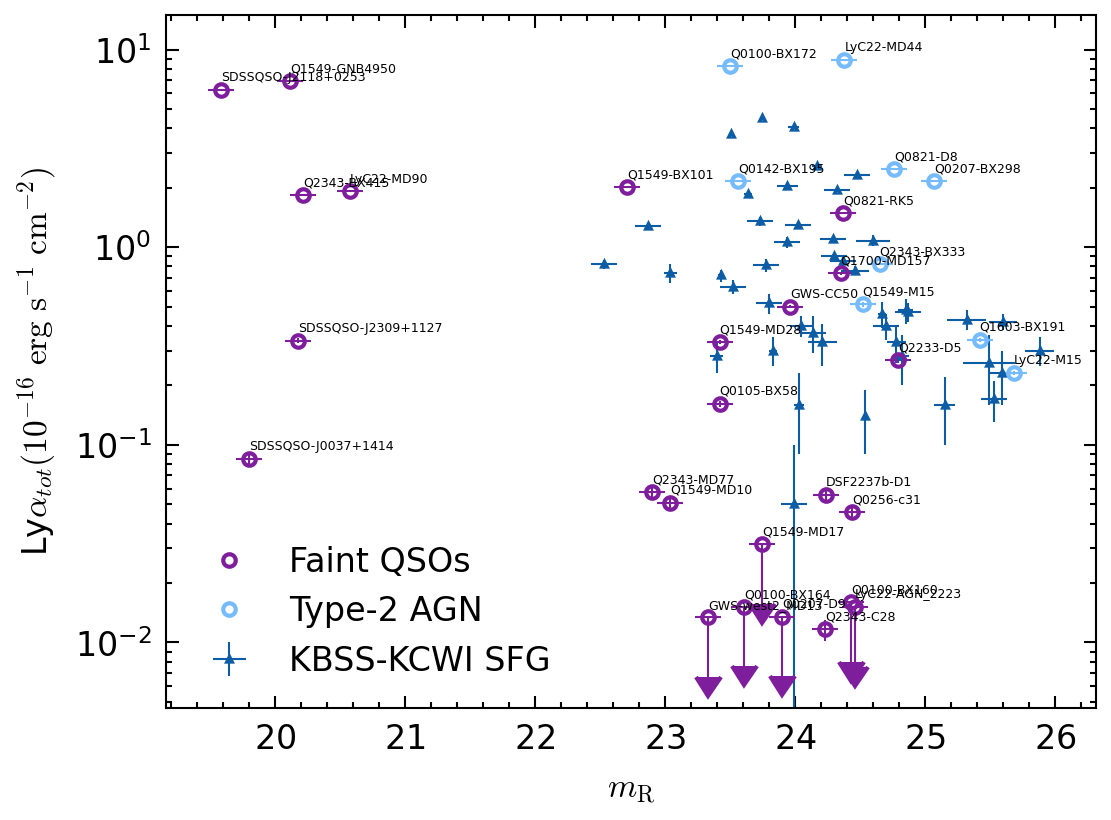

In [428]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
from scipy import interpolate
Kcorr_tab=np.genfromtxt(KBSSpath+"/Kcorr_org.csv",delimiter=" ")

Kcorr=interpolate.interp1d(Kcorr_tab[:,0],Kcorr_tab[:,1],fill_value="extrapolate")

filters = ["table['KCWI'] == 'yes'","table['Name'] != 'FSzP1170'","table['Name'] != 'Lab5'"]
update_table=True

dtype="KBSS"
source_table = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN.list",format="ipac")

all_directories,tab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"))

Pub_filt=["sdss.up","sdss.gp","sdss.rp","sdss.ip","sdss.zp","WISE1","WISE2","WISE3","WISE4","2mass.J","2mass.H","2mass.Ks"]

fig,axs=plt.subplots(figsize=(4,3),dpi=300)

axs.errorbar(merged_set["MRs"],merged_set["Lyatot"]*0.1,xerr=merged_set["MRserr"],ms=1,lw=0.5,yerr=merged_set["Lyatoterr"]*0.1,fmt="^",label="KBSS-KCWI SFG")

metrics=line_total_flux#



#metrics2=mstar_2
#metrics1=mstar_1
ms=3
lw=0.5
photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"
tfs=3
Lyatot=[]
Lyatoterr=[]
Mi2=[]
upper=[]
for ind,sentry in enumerate(tab):
    sourcename=sentry["Name"]
    fieldnow = sentry["Field"]
    Qtype = sentry["Type"]
    fullname=fieldnow+"-"+sourcename
    if sentry["zneb"]>0:
        redshift=sentry["zneb"]
    elif sentry["zabs"]>0:
        redshift=sentry["zabs"]
    else:
        redshift=sentry["zlya"]
    #ld=Planck18.luminosity_distance(redshift).to(u.cm).value
    #S=4*np.pi*ld
    sld=Planck18.luminosity_distance(redshift).to(u.cm).value**2*4*np.pi*1e-16
    print()
    if fullname in Lya_3arc.keys():
        mRs = sentry['R']
        #mi = mRs-0.1
        #mu= 5.*np.log10(Planck18.luminosity_distance(sentry["z_sys"]).to(u.pc).value)-5 #distance modulus
        #Mi.append(iAB-mu)
        #Mi2.append(mi-mu-Kcorr(redshift))
        mRserr = 0.1#photentry["col{}".format(3+2*filtind)][0]
        uplims=False
        if (metrics[fullname][0] <= 3*metrics[fullname][1]) or (metrics[fullname][1]<=1e-3):
            uplims=True
            upper.append(1)
            y_toplot = 2*metrics[fullname][1]
            y_tosave = 2*line_total_flux[fullname][1]
            #y_tosave_err = metrics[fullname][1]
        else:
            upper.append(0)
            y_tosave = line_total_flux[fullname][0]
            y_toplot = metrics[fullname][0]
        print(y_toplot)
        Lyatot.append(y_tosave*sld)
        Lyatoterr.append(line_total_flux[fullname][1]*sld)
        #Lyatot.append(y_toplot*sld)
        #Lyatoterr.append(metrics[fullname][1]*sld)
        if Qtype<2:
            color="xkcd:Purple"
        else:
            color="xkcd:sky blue"
        axs.errorbar(mRs,y_toplot,xerr=mRserr,yerr=metrics[fullname][1],uplims=uplims,mfc="None",fmt="o",lw=lw,ms=ms,color=color)
        #else:
        #    axs.errorbar(metrics2[0][ind],metrics[sourcename][0],xerr=metrics2[1][ind],yerr=metrics[sourcename][1],fmt="*",color=colorlst[0])
        jitter=np.random.random()
        axs.text(mRs,y_toplot*(1+0.11),fullname,fontsize=tfs,color="k")#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)
#newid1=filtered_id_1.insert(-1,"Q1623-KP76")
from astropy.table import Table, Column
if update_table:
    tab.add_column(Column(name='Lyatot', data=Lyatot))
    tab.add_column(Column(name='Lyatot_err', data=Lyatoterr))
    tab.add_column(Column(name='UpperLim', data=upper))
#qsos_bright.add_column(Column(name='z_Lyaneb', data=z_Lyaneb))
    ascii.write(tab,KBSSpath+"/KCWI/KBSS_faint_AGN_short_updated_2.list",format="ipac",overwrite=True)
axs.set_yscale("log")

from matplotlib.lines import Line2D
proxy_line1 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color="xkcd:Purple", label="Faint QSOs")
proxy_line2 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color="xkcd:sky blue", label="Type-2 AGN")
axs.legend()
axs.set_xlabel(r"$m_{\rm R}$")
axs.set_ylabel(r"Ly$\alpha_{tot} (10^{-16}~\rm erg~s^{-1}~cm^{-2})$")
#axs.set_xscale
#axs.set_xlim([22,26])


axs.set_ylim([-1,15])
#axs.set_yticks([1e-2,1e-1,1,5,10])
#axs.set_yticklabels([r"10$^{-2}$",r"10$^{-1}$","1","5","10"])



#axs.set_xscale("symlog")
#fig.savefig(KBSSpath+"/fig/Lya_MRs.pdf")

In [449]:

source_table = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN_KCWIobserved_MBH.list",format="ipac")
dtype="KBSS"
filters=["table['KCWI']=='yes'","table['Name'] == 'BX333'"]
all_directories,qsotab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"),channel="red")
reload(my_util)

<module 'my_util' from '/disk/bifrost/yuanze/multiAGN/scripts/my_util.py'>

Written cleaned cube to /disk/bifrost/yuanze/KBSS/Q2343/BX333/kcwir/Q2343-BX333-red_icubes_wcs_cleaned.fits


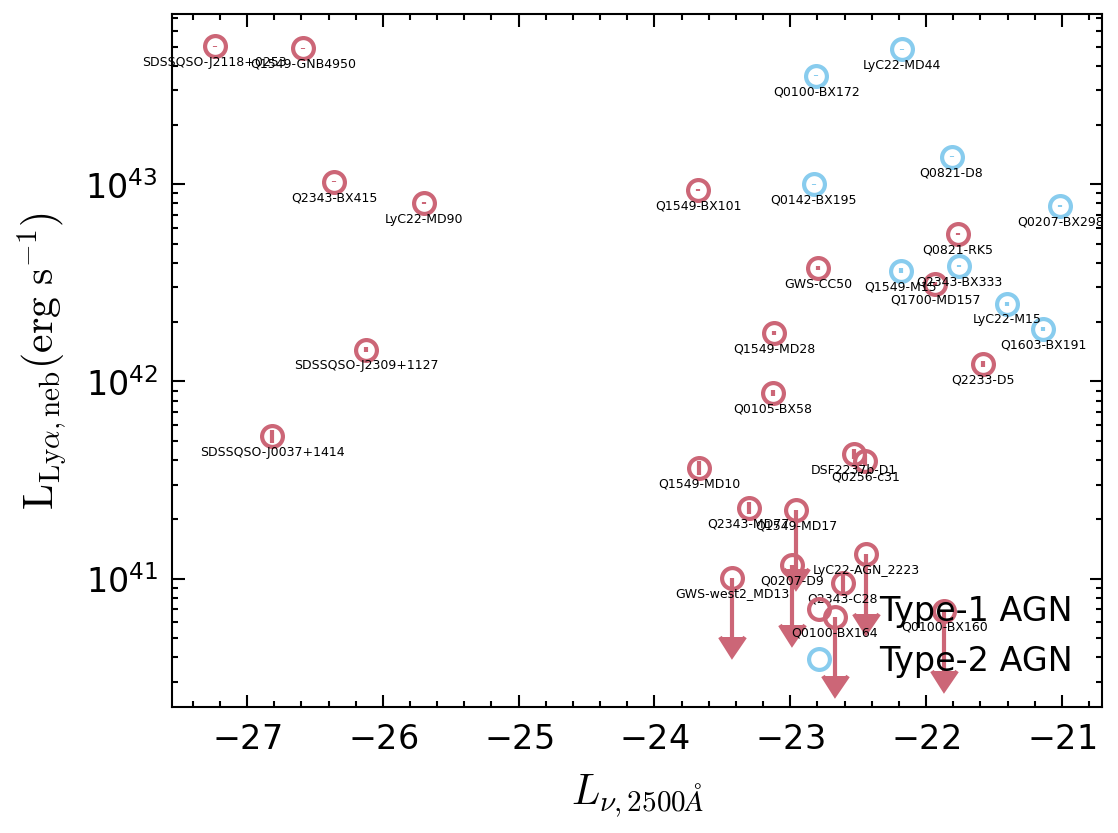

In [468]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
from dustmaps.sfd import SFDQuery
from dust_extinction.parameter_averages import G23

sfd = SFDQuery()
ext_model = G23(Rv=3.1)


colorlst=["#CC6677","#88CCEE","#6699CC"]
fig,axs=plt.subplots(figsize=(4,3),dpi=300)
#axins=axs.inset_axes([1.05,0.1,0.8,0.8])

fy=[]
fx=[]
fyerr=[]
fxerr=[]

exclude=["Q1623-KP78","Q1623-KP76"]
fyall=[]
fxall=[]
fyerrall=[]
metrics=line_total_flux
line_total_luminosity={}
line_average_SB={}

ms=5
photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"
tfs=3
band="i"
qsos_bright = ascii.read(KBSSpath+"/KCWI/qsos_bright_updated.list",format="ipac")
qsos_faint2 = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN_short_updated_2.list",format="ipac")

source_table = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN_short_updated.list",format="ipac")
dtype="KBSS"
filters=["table['KCWI']=='yes'","table['Name'] != 'FSzP1170'","table['Name'] != 'Lab5'"]
all_directories,qsotab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"),channel="red")


Lyaneb_faintQSO=qsos_faint2["Lyatot"]
Lyaneberr_faintQSO=qsos_faint2["Lyatot_err"]
Lyaneb_faintQSO_UpperLim=qsos_faint2["UpperLim"].astype(bool)

#xval=qsotab["Mi_2"].data.data.astype("float")#qsotab["Lnu2500_intrin"].data.data.astype("float")
#xerr=None#qsotab["Mi_2"].data.data.astype("float")
faint_type1=qsotab["Type"].astype(float)<1.9

mbh_all = qsotab["MBH"].data.data.astype(float)        # NEW
valid = np.isfinite(mbh_all) & (mbh_all > 0)   # NEW

log_mbh_all = np.log10(mbh_all[valid])         # LOG scaling here
log_mbh_min = np.nanmin(log_mbh_all)
log_mbh_max = np.nanmax(log_mbh_all)

def mbh_to_alpha(m):
    """
    Map MBH to alpha in [0.2, 1.0] using log10(MBH)
    (higher mass = more opaque).
    """
    if not np.isfinite(m) or m <= 0:
        return 0.0

    log_m = np.log10(m)
    if log_mbh_max == log_mbh_min:
        return 1.0

    frac = (log_m - log_mbh_min) / (log_mbh_max - log_mbh_min)
    return 0.2 + 0.8 * np.clip(frac, 0.0, 1.0)


for ind,sentry in enumerate(qsotab):
    
    #sourcename=re.findall(r"-(.*)",id)[0]
    field=sentry["Field"]
    name=sentry["Name"]
    #try:
        #my_util.fix_kcwi_cube(all_directories[ind]+f"/{field}-{name}-red_icubes_wcs.fits",all_directories[ind]+f"/{field}-{name}-red_icubes_wcs_cleaned.fits",bad_value=1e3)
    #except FileNotFoundError:
     #   print(all_directories[ind]+f"/{field}-{name}-red_icubes_wcs.fits","file not found")
    sourcename=sentry["Field"]+"-"+sentry["Name"]
    #print(sourcename)    
    thisqsoind=(qsos_faint2["Name"]==name) & (qsos_faint2["Field"]==field)
    y = qsos_faint2[thisqsoind]["Lyatot"]
    yerr = qsos_faint2[thisqsoind]["Lyatot_err"]
    uplims=qsos_faint2[thisqsoind]["UpperLim"].astype(bool)
    
    stype=float(sentry["Type"])
   # if valid[ind]:
   #     mbh = np.float64(sentry["MBH"])
   #     mbh_err = np.float64(sentry["MBH_err"])
   # else:
   #     mbh=np.nan
   #     mbh_err=np.nan
   # alpha = mbh_to_alpha(mbh)
    x = float(sentry["Mi_2"])
    xerr = None#float(sentry["Lnu2500_intrin_err"])
    if stype<=1.9:
        axs.errorbar(x,y,xerr=xerr,yerr=yerr,fmt="o",uplims=uplims,mfc="None",ms=ms,alpha=1,color=colorlst[0])
    else:
        axs.errorbar(x,y,xerr=xerr,yerr=yerr,fmt="o",uplims=uplims,mfc="None",ms=ms,color=colorlst[1])
    axs.text(x,y*0.9,sourcename,fontsize=tfs,horizontalalignment='center',verticalalignment='top')#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)

from matplotlib.lines import Line2D
proxy_line1 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[0], label="Type-1 AGN")
proxy_line2 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[1], label="Type-2 AGN")
#axs.legend()
axs.set_xlabel(r"$L_{\nu,2500\AA}$",fontsize=10)

axs.set_ylabel(r"$\rm L_{Ly\alpha,neb} (erg~s^{-1})$",fontsize=10)


axs.set_yscale("log")
#axs.set_xscale("log")


axs.legend(loc="lower right",markerfirst=True)


## assumption 1: Mstar-MBH holds at z~2-3
## assumption 2: high mass galaxies tend to have more extended gas halo and higher gas convering fraction

## result 1: We are sampling AGNs with similar MBH
## result 2: mild correlation exist between QSOs' L_Lya,neb and UV continuum luminosity

## speculation 2: CGM brightness (gas covering fraction) may primarily correlate with galaxy size/stellarmass?
## speculation 3: some of the AGNs are showing very low level of CGM Lya emission because they are systems with higher eddington ratio --> looks brighter than galaxies with similar stellar mass


In [467]:
qsos_faint2["Lyatot"]

6.828211657766298e+40
6.417442686559543e+40
3.55805552634314e+43
8.737157285063106e+41
1.0017630951232924e+43
7.748662432613688e+42
1.1685379781329292e+41
3.973587544527837e+41
5.58207197381397e+42
1.379193418753799e+43
9.34993929756176e+42


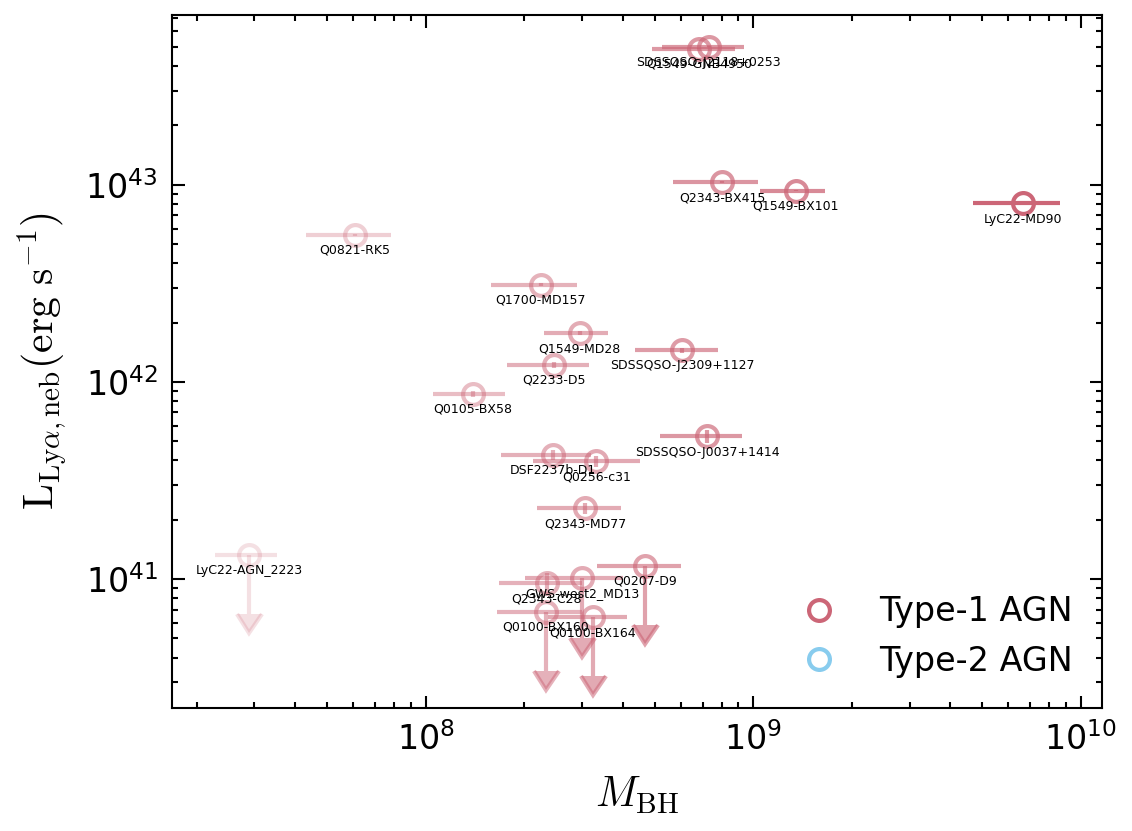

In [441]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
from dustmaps.sfd import SFDQuery
from dust_extinction.parameter_averages import G23

sfd = SFDQuery()
ext_model = G23(Rv=3.1)


colorlst=["#CC6677","#88CCEE","#6699CC"]
fig,axs=plt.subplots(figsize=(4,3),dpi=300)
#axins=axs.inset_axes([1.05,0.1,0.8,0.8])

fy=[]
fx=[]
fyerr=[]
fxerr=[]

exclude=["Q1623-KP78","Q1623-KP76"]
fyall=[]
fxall=[]
fyerrall=[]
metrics=line_total_flux
line_total_luminosity={}
line_average_SB={}

ms=5
photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"
tfs=3
band="i"
qsos_bright = ascii.read(KBSSpath+"/KCWI/qsos_bright_updated.list",format="ipac")
qsos_faint2 = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN_short_updated_2.list",format="ipac")

source_table = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN_KCWIobserved_MBH.list",format="ipac")
dtype="KBSS"
filters=["table['KCWI']=='yes'","table['Name'] != 'FSzP1170'","table['Name'] != 'Lab5'"]
all_directories,qsotab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"))


Lyaneb_faintQSO=qsos_faint2["Lyatot"]
Lyaneberr_faintQSO=qsos_faint2["Lyatot_err"]
Lyaneb_faintQSO_UpperLim=qsos_faint2["UpperLim"].astype(bool)

xval=qsotab["Lnu2500_intrin"].data.data.astype("float")
xerr=qsotab["Lnu2500_intrin_err"].data.data.astype("float")
faint_type1=qsotab["Type"].astype(float)<1.9

mbh_all = qsotab["MBH"].data.data.astype(float)        # NEW
valid = np.isfinite(mbh_all) & (mbh_all > 0)   # NEW

log_mbh_all = np.log10(mbh_all[valid])         # LOG scaling here
log_mbh_min = np.nanmin(log_mbh_all)
log_mbh_max = np.nanmax(log_mbh_all)

def mbh_to_alpha(m):
    """
    Map MBH to alpha in [0.2, 1.0] using log10(MBH)
    (higher mass = more opaque).
    """
    if not np.isfinite(m) or m <= 0:
        return 0.0

    log_m = np.log10(m)
    if log_mbh_max == log_mbh_min:
        return 1.0

    frac = (log_m - log_mbh_min) / (log_mbh_max - log_mbh_min)
    return 0.2 + 0.8 * np.clip(frac, 0.0, 1.0)


for ind,sentry in enumerate(qsotab):
    #sourcename=re.findall(r"-(.*)",id)[0]
    field=sentry["Field"]
    name=sentry["Name"]
    sourcename=sentry["Field"]+"-"+sentry["Name"]
    #print(sourcename)    
    thisqsoind=(qsos_faint2["Name"]==name) & (qsos_faint2["Field"]==field)
    y = qsos_faint2[thisqsoind]["Lyatot"]
    yerr = qsos_faint2[thisqsoind]["Lyatot_err"]
    uplims=qsos_faint2[thisqsoind]["UpperLim"].astype(bool)
    
    stype=float(sentry["Type"])
    if valid[ind]:
        mbh = np.float64(sentry["MBH"])
        mbh_err = np.float64(sentry["MBH_err"])
    else:
        mbh=np.nan
        mbh_err=np.nan
        continue
    alpha = mbh_to_alpha(mbh)
    x = mbh#float(sentry["Lnu2500_intrin"])
    xerr = mbh_err#float(sentry["Lnu2500_intrin_err"])
    if stype<=1.9:
        axs.errorbar(x,y,xerr=xerr,yerr=yerr,fmt="o",uplims=uplims,mfc="None",ms=ms,alpha=alpha,color=colorlst[0])
    else:
        axs.errorbar(x,y,xerr=xerr,yerr=yerr,fmt="o",uplims=uplims,mfc="None",ms=ms,alpha=alpha,color=colorlst[1])
    axs.text(x,y*0.9,sourcename,fontsize=tfs,horizontalalignment='center',verticalalignment='top')#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)

from matplotlib.lines import Line2D
proxy_line1 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[0], label="Type-1 AGN")
proxy_line2 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[1], label="Type-2 AGN")
#axs.legend()
axs.set_xlabel(r"$M_{\rm BH}$",fontsize=10)#$L_{\nu,2500\AA}$",fontsize=10)

axs.set_ylabel(r"$\rm L_{Ly\alpha,neb} (erg~s^{-1})$",fontsize=10)


axs.set_yscale("log")
axs.set_xscale("log")


axs.legend(loc="lower right",markerfirst=True)


## update table with relavent physical information

In [283]:
from scipy import interpolate
sys.path.append('/disk/bifrost/yuanze/multiAGN/scripts')
import my_util
import importlib
importlib.reload(my_util)
source_table = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN.list",format="ipac")
dtype="KBSS"
filters=["table['KCWI']=='yes'"]
all_directories,qsotab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"))


save_to_path=KBSSpath+"/KCWI/KBSS_faint_AGN_KCWIobserved.list"
best_blr_line = {
    "Q0100-BX160": "CIV",
    "Q0100-BX164": "Halpha",
    "Q0105-BX58": "Halpha",
    "Q0207-D9": "CIV",
    "Q0256-c31": "CIV",
    "Q0821-RK5": "Halpha",
    "Q1549-BX101": "Halpha",
    "Q1549-GNB4950": "CIV",
    "Q1549-MD10": "Lya",
    "Q1549-MD17": "Lya",
    "Q1549-MD28": "Halpha",
    "Q1700-MD157": "CIV",
    "Q2233-D5": "CIV",
    "Q2343-C28": "CIV",
    "Q2343-MD77": "CIV",
    "Q2343-BX415": "CIV",
    "GWS-west2_MD13": "CIV",
    "DSF2237b-D1": "CIV",
    "LyC22-AGN_2223": "Hbeta",
    "LyC22-MD90": "Halpha",
}

Line_best_fwhm = {
    "Q0100-BX160": [4256, 585],
    "Q0100-BX164": [5941, 481],
    "Q0207-D9": [8913, 814],
    "Q0256-c31": [9969, 4597],
    "Q1549-GNB4950": [6810, 29],
    "Q1549-MD28": [7109,121],
    "Q1700-MD157": [5831, 1055],
    "Q2233-D5": [7218, 387],
    "Q2343-C28": [4216, 305],
    "Q2343-MD77": [4442, 473],
    "Q2343-BX415": [8519, 1305],
    "GWS-west2_MD13": [5009, 1813],
    "DSF2237b-D1": [4024, 1050],
    "Q0105-BX58": [2400, 299],
    "Q0821-RK5": [4153, 1390],
    "Q1549-BX101": [7061, 27],
    "LyC22-AGN_2223": [4389,75],
    "LyC22-MD90": [8424.7, 4.1],
}

my_util.update_KBSS_tab_multi({"MBH_line":best_blr_line,"line_FWHM":Line_best_fwhm},qsotab,save_to_path,name_of_parameter="MBH_line",overwrite=False)



Q0100-BX172 not assigned, adding blank
Q0142-BX195 not assigned, adding blank
Q0207-BX298 not assigned, adding blank
Q0821-D8 not assigned, adding blank
Q1549-Lab5 not assigned, adding blank
Q1549-M15 not assigned, adding blank
Q1603-BX191 not assigned, adding blank
Q2343-FSzP1170 not assigned, adding blank
Q2343-BX333 not assigned, adding blank
GWS-CC50 not assigned, adding blank
LyC22-M15 not assigned, adding blank
LyC22-MD44 not assigned, adding blank
SDSSQSO-J2309+1127 not assigned, adding blank
SDSSQSO-J2118+0253 not assigned, adding blank
SDSSQSO-J0037+1414 not assigned, adding blank
Updated the qsos table
Q0100-BX172 not assigned, adding blank
Q0142-BX195 not assigned, adding blank
Q0207-BX298 not assigned, adding blank
Q0821-D8 not assigned, adding blank
Q1549-Lab5 not assigned, adding blank
Q1549-M15 not assigned, adding blank
Q1549-MD10 not assigned, adding blank
Q1549-MD17 not assigned, adding blank
Q1603-BX191 not assigned, adding blank
Q2343-FSzP1170 not assigned, adding b

0

In [318]:
MBH_Shen2012

[246656004.43037248,
 177893654.21977326,
 78093113.99642263,
 466024822.8059152,
 314575719.8535238,
 31980024.58461507,
 366479290.10380626,
 686878706.8886596,
 61723408.95697311,
 227265104.09024513,
 216101014.19543996,
 193465570.96313086,
 306882681.92201006,
 804618548.9234109,
 293439135.8659692,
 215483871.0726404,
 19427731.741171863,
 4802806918.254536]

In [437]:
import my_util
import importlib
importlib.reload(my_util)
spath=KBSSpath+"/KCWI/KBSS_faint_AGN_KCWIobserved_updated.list"
save_to_path=KBSSpath+"/KCWI/KBSS_faint_AGN_KCWIobserved_MBH.list"
#save_to_path=KBSSpath+"/KCWI/KBSS_faint_AGN_KCWIobserved_updated.list"

source_table = ascii.read(spath,format="ipac")
dtype="KBSS"
filters = ["table['KCWI'] == 'yes'"]

all_directories,qsotab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"))


#my_util.update_KBSS_tab_multi({"continuum_lum":best_continuum_lum,"Lnu2500_intrin":Lnu2500_intrin},qsotab,save_to_path,overwrite=True)
best_MBH={}
MBH_Shen2012=[]
MBH_Shen2012_err=[]

Lnu2500=[]
Lnu2500_err=[]
for sentry in qsotab:
    if float(sentry["line_FWHM"]) is not np.nan:
        linename=sentry["MBH_line"]
        FWHM=[float(sentry["line_FWHM"])/1000,float(sentry["line_FWHM_err"])/1000]
        Llam=[float(sentry["continuum_lum"])/1e44,float(sentry["continuum_lum_err"])/1e44]
    else:
        continue
    MBH,sigma=my_util.FWHM_to_MBH_Shen2012(FWHM,Llam,linename)
    best_MBH[sentry["Field"]+"-"+sentry["Name"]]=[MBH,MBH*sigma]
    MBH_Shen2012.append(MBH)
    MBH_Shen2012_err.append(MBH*sigma)

    Lnu2500.append(float(sentry["Lnu2500_intrin"]))
    Lnu2500_err.append(float(sentry["Lnu2500_intrin_err"]))

/tmp/ipykernel_2968135/823425781.py:23: UserWarning: Warning: converting a masked element to nan.
  if float(sentry["line_FWHM"]) is not np.nan:


In [438]:
best_MBH

{'Q0100-BX160': [232665127.39143088, 67101894.41996382],
 'Q0100-BX164': [323155032.3223559, 87432486.66542512],
 'Q0105-BX58': [139596039.11381304, 34397247.62377582],
 'Q0207-D9': [466783634.1806687, 132714378.78404546],
 'Q0256-c31': [331719762.4299269, 119093136.31825267],
 'Q0821-RK5': [60885911.62622901, 17645054.76413426],
 'Q1549-BX101': [1350090868.4797444, 300454979.0689909],
 'Q1549-GNB4950': [684533959.0840069, 192389596.4702507],
 'Q1549-MD28': [294721205.04961205, 65631220.25604497],
 'Q1700-MD157': [224368849.72077417, 65893778.91117777],
 'Q2233-D5': [245959495.06731164, 69416017.78828798],
 'Q2343-C28': [234166838.69100663, 66448765.19108292],
 'Q2343-MD77': [306886971.62411994, 87612534.52414024],
 'Q2343-BX415': [802925563.3345674, 232980228.70042875],
 'GWS-west2_MD13': [300227910.4455478, 98779066.17654888],
 'DSF2237b-D1': [244142086.75121424, 74921299.51154558],
 'LyC22-AGN_2223': [28945945.875991073, 6261256.622228114],
 'LyC22-MD90': [6667339028.563741, 1980959

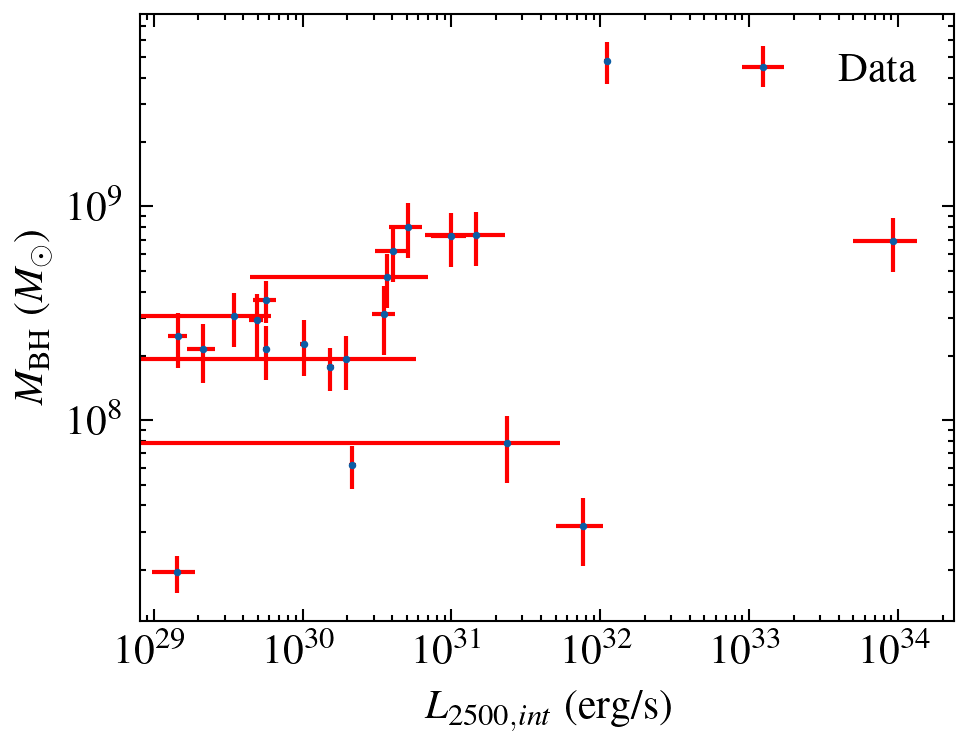

In [435]:
plt.style.use(["science"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})
plt.figure(dpi=300)
from scipy.odr import ODR, Model, RealData
def linear_func(params, x):
    m, c = params
    return m * x + c

plt.errorbar(Lnu2500,MBH_Shen2012,xerr=Lnu2500_err,yerr=MBH_Shen2012_err,fmt="o",ms=0.8,ecolor="r",label="Data")

xfit=np.log(np.array(Lnu2500))
xfit_err=np.array(Lnu2500_err)/np.array(Lnu2500)
yfit=np.log(np.array(MBH_Shen2012))
yfit_err=np.array(MBH_Shen2012_err)/np.array(MBH_Shen2012)
#res=scipy.stats.linregress(xfit,yfit)

#data = RealData(xfit, yfit, sy=yfit_err)

# Define a model
#model = Model(linear_func)

# Set up ODR
#odr = ODR(data, model, beta0=[1., -10.])  # Initial guess for m and c

# Run ODR
#output = odr.run()

# Results
#print("Slope (m):", output.beta[0])
#print("Intercept (c):", output.beta[1])
#print("Covariance matrix:", output.cov_beta)
#print("Residual variance:", output.res_var)

#Q1217+490 24300.51 0.0994027   10.5689    -106.3 0.0616586      161.        1987.7      2.7017   Ha 
#Q1623-KP77 17188.15 1.819E-27 1.137E-25    -62.51 1.002E-27     106.6        1860.6      2.5347  Hb

#plt.plot(10**xfit,10**(res.intercept+res.slope*xfit),"m",label="HLQSOs")
#plt.plot(np.exp(xfit),np.exp(output.beta[1]+output.beta[0]*xfit),"m",label="Model")
plt.ylabel("$M_\mathrm{BH}$ ($M_{\odot}$)")
plt.xlabel("$L_{2500,int}$ (erg/s)")
plt.yscale("log")
plt.xscale("log")
ax=plt.gca()
ax.legend()
#ax.ticklabel_format(axis = 'y', style='sci', scilimits = (0,0))
#ax.yaxis.set_ticks([5e9,1e10,4e10])
#ax.yaxis.set_ticklabels(ticklabels = [r"$5\times 10^{9}$",r"$1\times 10^{10}$",r"$4\times 10^{10}$"])

#ax.xaxis.set_ticks([5e46,1e47,3e47])
#ax.xaxis.set_ticklabels(ticklabels = [r"$5\times 10^{46}$",r"$1\times 10^{47}$",r"$3\times 10^{47}$"])
#ax.text(0.05,0.75,r"$\lambda_\mathrm{Edd}\simeq $ %.2f"%lambda_edd,ha="left",va="top",transform=ax.transAxes)

In [439]:
my_util.update_KBSS_tab_multi({"MBH":best_MBH},qsotab,save_to_path,overwrite=True)


Q0100-BX172 not assigned for MBH, adding blank
Q0142-BX195 not assigned for MBH, adding blank
Q0207-BX298 not assigned for MBH, adding blank
Q0821-D8 not assigned for MBH, adding blank
Q1549-Lab5 not assigned for MBH, adding blank
Q1549-M15 not assigned for MBH, adding blank
Q1549-MD10 not assigned for MBH, adding blank
Q1549-MD17 not assigned for MBH, adding blank
Q1603-BX191 not assigned for MBH, adding blank
Q2343-FSzP1170 not assigned for MBH, adding blank
Q2343-BX333 not assigned for MBH, adding blank
GWS-CC50 not assigned for MBH, adding blank
LyC22-M15 not assigned for MBH, adding blank
LyC22-MD44 not assigned for MBH, adding blank
Updated the QSOs table with: MBH


0

In [9]:
source_table = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN.list",format="ipac")
dtype="KBSS"
filters=["table['KCWI']=='yes'"]
all_directories,tab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"))

In [16]:
ascii.write(tab["RA","Decl"], 'RA_Decl_faintQSO.dat', format='csv',overwrite=True)

## Do absorption line fittings for all faint QSO

In [49]:
sys.path.append("/disk/bifrost/yuanze/software/AbsorpFit")
import LineModels as LM
from scipy import signal
reload(ctools)
ascii_file_path = KBSSpath+'/KCWI/KBSS_faint_AGN.list'  # Path to the ASCII file
source_table = ascii.read(ascii_file_path, format='ipac')
dtype="KBSS"
filters = ["table['KCWI'] == 'yes'","table['Name'] != 'FSzP1170'","table['Name'] != 'Lab5'"]
all_directories,qsotab,data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"),channel="red")


savetopath=KBSSpath+"/faint_qsos/result/absfit_result"




In [21]:
redshift

-1.0

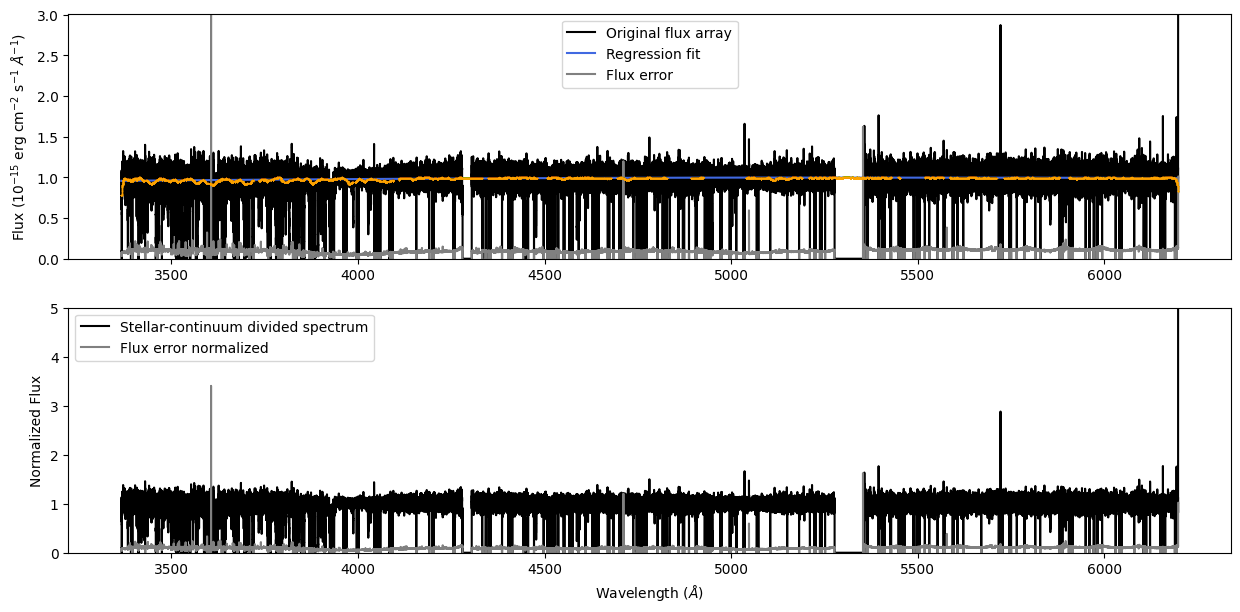

In [169]:

#Heavy median filter to remove fluctuations

sys.path.append('/disk/bifrost/yuanze/multiAGN/scripts')
import my_util
import importlib
importlib.reload(my_util)

manual_reset=True
use_fitted=True
if manual_reset:
    #sdic={"Field":"MQN01","Name":"CTSG18.01","zlya":3.207,"instru":"UVES"}
    sdic={"Field":"Slug","Name":"UM287","zlya":2.283,"instru":"HIRES"}
    tab=[sdic]
    instru=sdic["instru"]
else:
    tab=qsotab[qsotab["Name"]=="MD157"]
    instru="kcwi"
#postfix="_red"
postfix=""

#qsotab[qsotab["Name"]=="MD157"]

for sentry in tab:#qsotab[qsotab["Name"]=="MD157"]:
    field=sentry["Field"]
    sname=sentry["Name"]
    redshift=sentry["zlya"]
    #if sentry["zneb"]>0:
    #    redshift=sentry["zneb"]
    #elif sentry["zabs"]>0:
    #    redshift=sentry["zabs"]
    #else:
    #    redshift=sentry["zlya"]
    try:
        if instru == "kcwi":
            gal   = fits.open(KBSSpath+"/faint_qsos/result/"+field+"-"+sname+"_kcwi_oned"+postfix+".fits")
            hdr = gal[1].header
            wHB = ((np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CD1_1'] + hdr['CRVAL1'])/(1+redshift)
            fHB, eHB = gal['SPEC'].data, np.sqrt(gal['VARIANCE'].data)
        #elif instru == "lris":
        elif instru == "HIRES":
            gal   = fits.open(KBSSpath+"/"+field+"/HIRES/"+sname+"_f.fits")
            gal_e = fits.open(KBSSpath+"/"+field+"/HIRES/"+sname+"_e.fits")
            hdr = gal[0].header
            wHB = 10**((np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CDELT1'] + hdr['CRVAL1'])
            fHB, eHB = gal[0].data, gal_e[0].data
            datamask = (np.abs(fHB)<1e2) & (np.abs(eHB)<1e2) & (~np.isnan(fHB)) &(fHB>1e-2) &(eHB>1e-2)
        elif instru == "UVES":
            gal   = fits.open(KBSSpath+"/"+field+"/UVES/"+sname+".fits")
            #hdr = gal[1].header
            
            #wHB = ((np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CDELT1'] + hdr['CRVAL1'])/(1+redshift)
            wHB, fHB, eHB = gal["SPECTRUM"].data["WAVE"][0], gal["SPECTRUM"].data["FLUX"][0], gal["SPECTRUM"].data["ERR"][0]
            datamask = (np.abs(fHB)<1e2) & (np.abs(eHB)<1e2) & (~np.isnan(fHB)) &(fHB>1e-2) &(eHB>1e-2)
    except FileNotFoundError:
        print(f"Red channel files for {field} {sname} not found. Skipping...")
        continue
    


    mylam=wHB#np.arange(1000,2000,0.5)
    #fakespec=np.ones(mylam.shape)
    specnew, ln_mylam, _ = my_util.log_rebin([mylam[0],mylam[-1]], fHB, velscale=1)
    newlam=np.exp(ln_mylam)
    mask0 = my_util.determine_mask(ln_mylam, [mylam[0],mylam[-1]], 0,z_instru=redshift, width=500)

    vpec=100
    mask1 = my_util.determine_mask(ln_mylam, [mylam[0],mylam[-1]], -vpec/3e5,z_instru=redshift, width=2000,broadline=True)
    if postfix == "_red":
        mask2 = (specnew>1e-3) & (np.exp(ln_mylam)*(1+redshift)<8860) & (np.exp(ln_mylam)*(1+redshift)>5680)
    elif instru == "kcwi":
        mask2 = (specnew>1e-3) & (np.exp(ln_mylam)*(1+redshift)<5580) & (np.exp(ln_mylam)*(1+redshift)>3500)
    elif instru == "UVES":
        mask2 = (specnew>0.5)
    elif instru == "HIRES":
        mask2 = (specnew>0.5)

    mask=np.ones(newlam.shape)
    #mask=mask1*mask0
    for m in [mask0,mask1,mask2]:
        mask *= m
    mask=mask.astype(bool)
    #maskwvl=newlam[~mask]
    #maskin=np.ones(len(newlam[~mask]))
    #goodpixels = my_util.spectralMasking(maskwvl,maskin,newlam)



    sclipped=sigma_clip(specnew[mask],sigma=3,maxiters=10)
    wave_to_fit = newlam[mask][~sclipped.mask]
    flux_to_fit = scipy.ndimage.median_filter(sclipped[~sclipped.mask], size=1001,mode="nearest") 
    flux_median = scipy.ndimage.median_filter(fHB, size=501,mode="nearest") 
    #Masking nan values
    
    #mask_next = np.isnan(wave_to_fit) | np.isnan(flux_to_fit) | (wave_to_fit < 912)|(sclipped.mask)
    z = np.polyfit(wave_to_fit, flux_to_fit,3)
    reg_fit = np.poly1d(z)

    ## Assigning the right variables 
    wave = wHB # Wavelength array
    if use_fitted:
        flux = fHB/reg_fit(wHB) # Continuum divided flux array
        err  = eHB/reg_fit(wHB) # Same operation must apply to the error array
    else:
        flux = fHB/flux_median # Continuum divided flux array
        err  = eHB/flux_median # Same operation must apply to the error array

    ## Plot both
    fig, (ax1, ax2) = plt.subplots(2,1, figsize = (15,7))
    ax1.plot(wave, fHB, c='k', drawstyle='steps-mid', label = 'Original flux array')
    ax1.plot(wave, reg_fit(wHB), c='royalblue', drawstyle='steps-mid', label = 'Regression fit')
    ax1.plot(wave, eHB, c='gray', drawstyle='steps-mid', label = 'Flux error')
    ax1.plot(wave_to_fit,flux_to_fit,"^",ms=0.1,color="orange")
    ax1.set_ylim(0,np.nanmedian(flux_to_fit)+2*np.nanmax(flux_to_fit))
    # ax1.set_xlabel(r'Wavelength ($\AA$)')
    ax1.set_ylabel(r'Flux (10$^{-15}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)')

    ax1.legend()

    ax2.plot(wave, flux, c='k', drawstyle='steps-mid', label = 'Stellar-continuum divided spectrum')
    ax2.plot(wave, err, c='gray', drawstyle='steps-mid', label = 'Flux error normalized')
    ax2.set_ylim(0,5)
    ax2.set_xlabel(r'Wavelength ($\AA$)')
    ax2.set_ylabel(r'Normalized Flux')
    ax2.legend()

    #fig.savefig(savetopath+"/continuum_"+field+"-"+sname+postfix+".pdf",dpi=300)
    #plt.close()
    FHWM_obs = 105
    LModel = LM.FitController(wave[datamask], flux[datamask], err[datamask], redshift = redshift, vdisp = FHWM_obs/2.355)
    #fig = LModel.plot_spectra()
    #fig = LModel.plot_lines(['HI','CIV','SiIV','CII','SiII','NV','FeII','MgII'],ylim=[-1,4])
    #fig.savefig(savetopath+"/lines_"+field+"-"+sname+postfix+".pdf",dpi=300)
    #plt.close()

# Continuum calibrated. Start line fitting

In [156]:
import line_fit


2.283

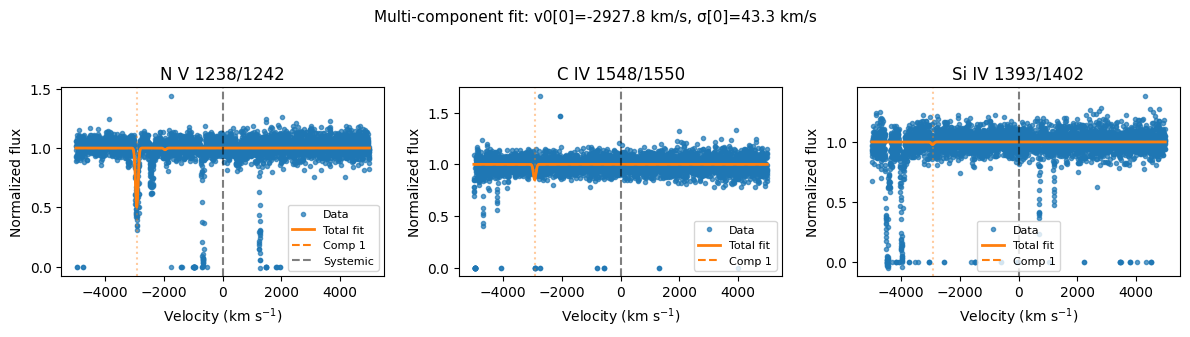

In [173]:
sys.path.append('/disk/bifrost/yuanze/multiAGN/scripts')
import line_fit
reload(line_fit)

v0_init = np.array([-2870.0])#, -3070.0])   # km/s
sigma_init = np.array([50.0])#, 5.0]) # km/s

res_multi = line_fit.fit_lines_multi_component(
    wave, flux,
    z_sys=redshift,
    v_window=5000.0,
    n_kin=1,
    v0_init=v0_init,
    sigma_init=sigma_init,
    use_groups=["NV","CIV","SiIV"],   # or e.g. ["OVI", "CIV"] if you want subset
    make_plot=True,
    fig_path=f"/disk/bifrost/yuanze/KBSS/faint_qsos/result/absfit_result/{field}_{sname}.pdf"
)


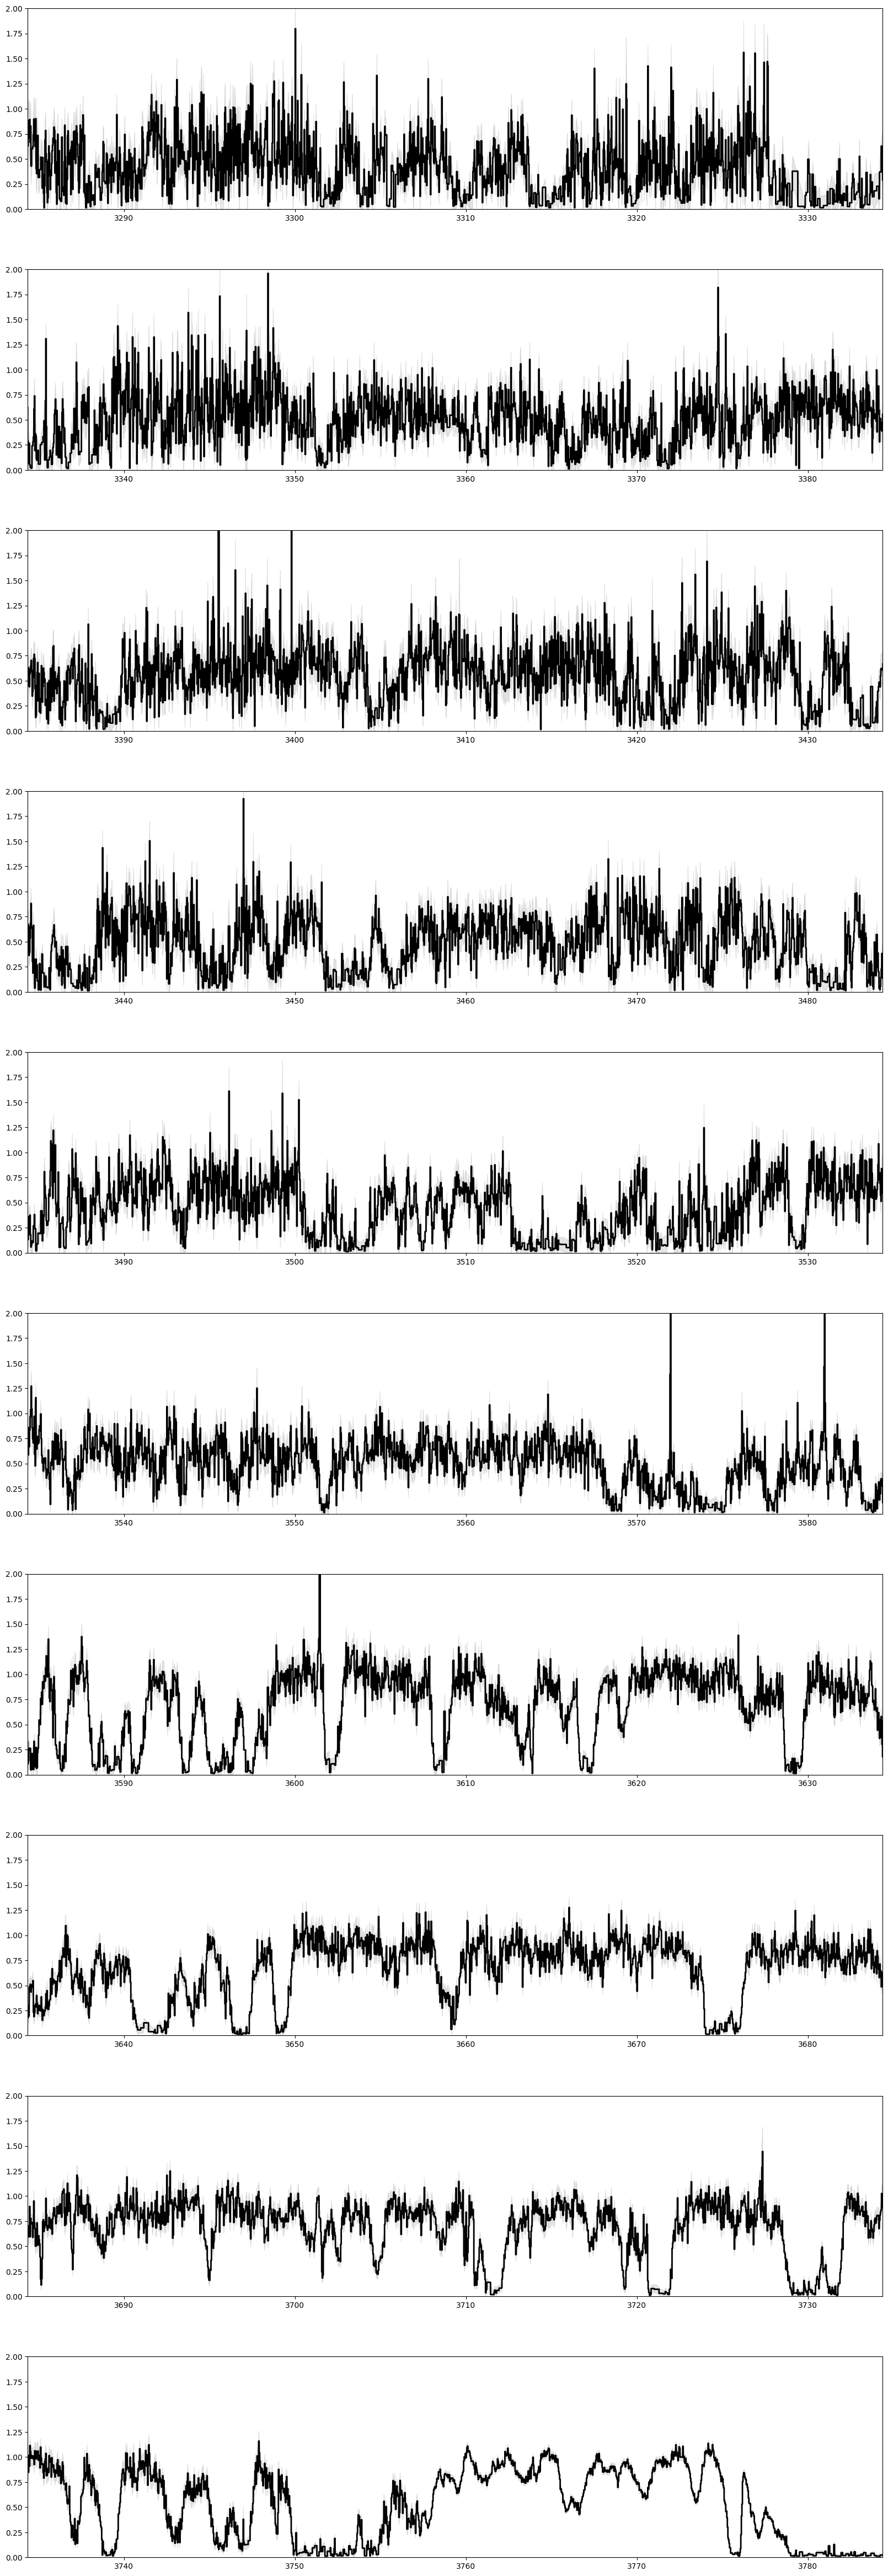

In [108]:
#LModel.plot_lines(['HI','CIV','SiIV','CII','SiII','NV','FeII','MgII'],xbounds=[3500,4200])
fig = LModel.plot_lines(['HI','CIV','SiIV','CII','SiII','NV','FeII','MgII'],xbounds=[5800,6300])
fig.savefig(savetopath+"/lines_"+field+"-"+sname+postfix+".pdf",dpi=300)




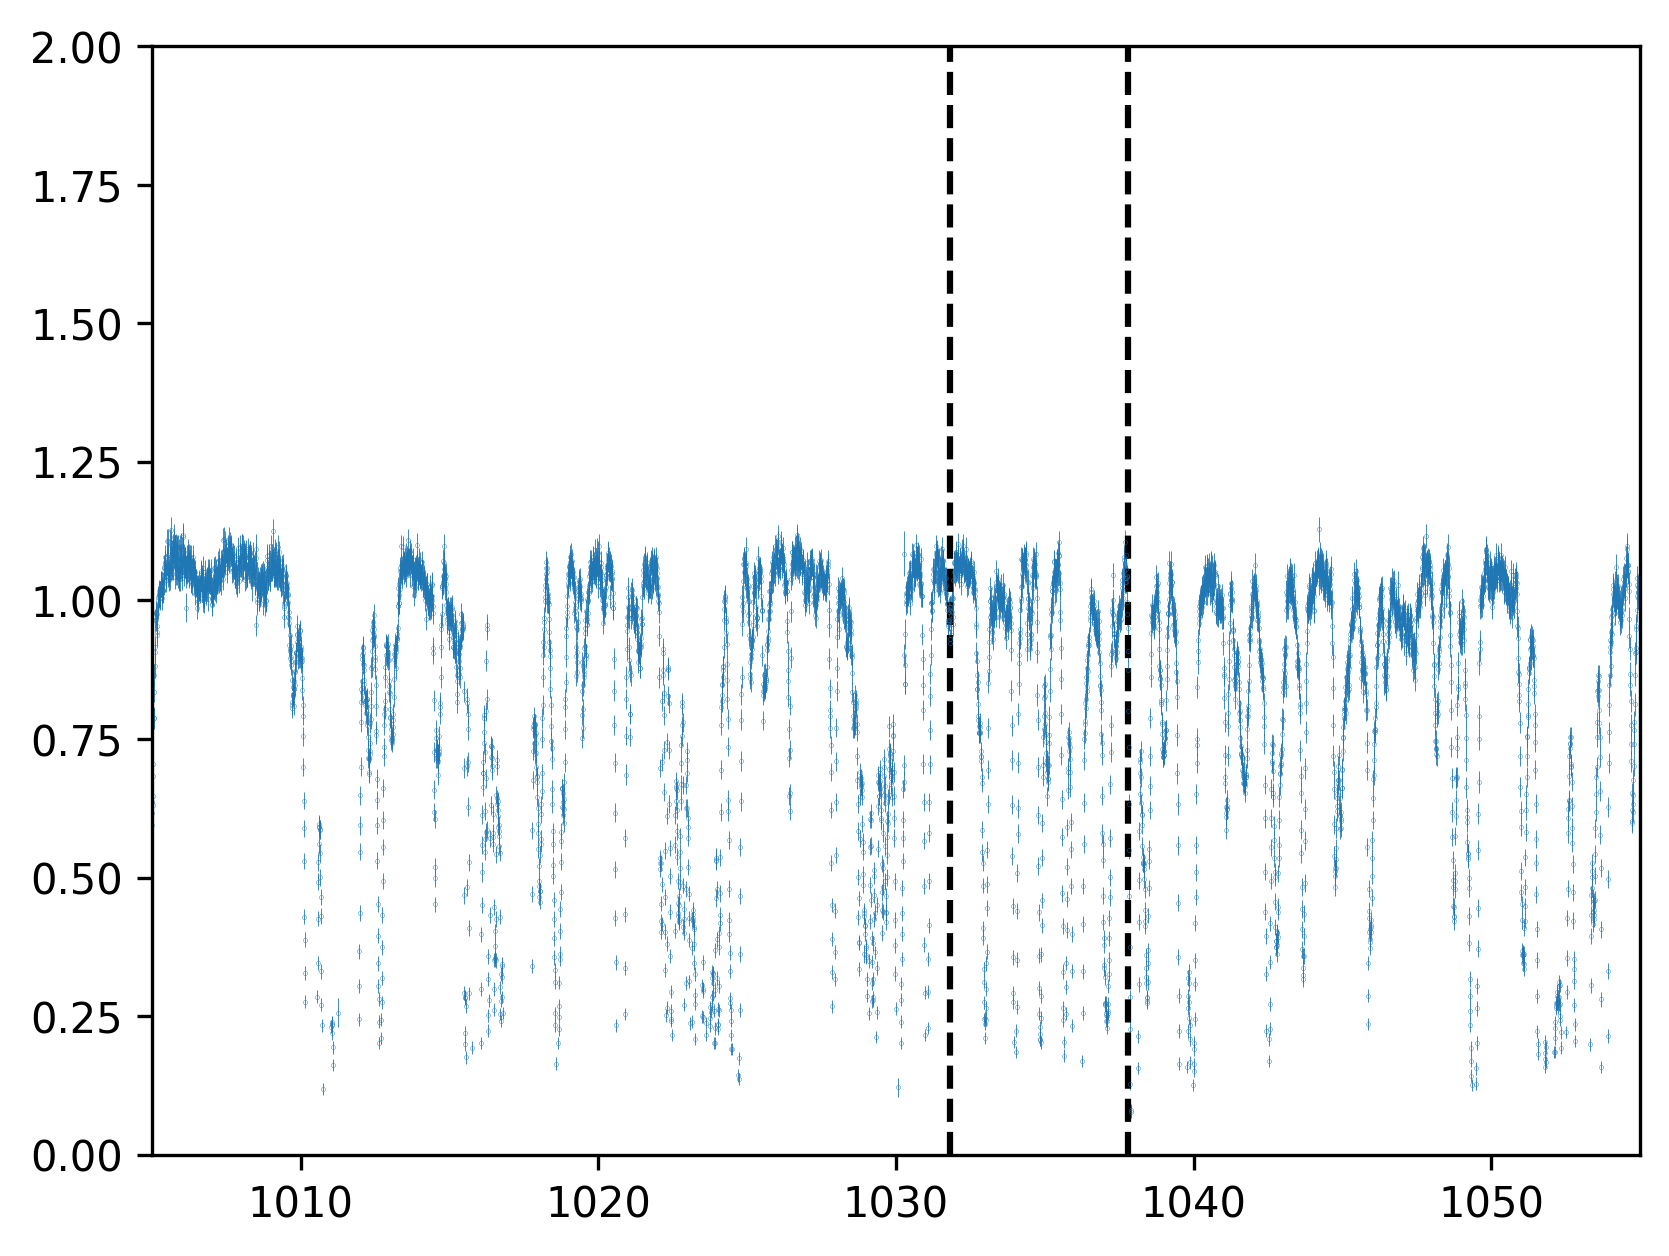

In [123]:
fig=plt.figure(dpi=300)
plt.errorbar(wave[datamask]/(1+3.267), flux[datamask], yerr=err[datamask],fmt="o",ms=0.1,lw=0.2)
plt.ylim([0.0,2])
plt.xlim([1005,1055])
#OVI
plt.axvline(1031.821,ls="--",color="k")
plt.axvline(1037.804,ls="--",color="k")
#NV
plt.axvline(1238.821)
plt.axvline(1242.804)

#Si II
plt.axvline(1259.519)
plt.axvline(1253.811)
plt.axvline(1250.584)
plt.axvline(1526.7066)

#Si IV
plt.axvline(1393.755)
plt.axvline(1402.77)

#C IV
plt.axvline(1549)
plt.axvline(1534)

#HI
plt.axvline(1215.67)



3.207

In [54]:
# Changing central value
#LModel.update_parameter('lognSiII', maxV= 16)
#LModel.update_parameter('lognNV', maxV= 16)
for species in ["NV","SiII"]:
    LModel.update_parameter('v'+species, minV= -3000,maxV=-700)
    LModel.update_parameter('v'+species, value= -1560)
    if species not in ["NV","CI"]:
        LModel.update_parameter('v'+species, expr = 'vNV')


#LModel.update_parameter('SiII', expr = 'bNV')
#LModel.update_parameter('vCI', expr = 'vNV')

# Changing bounds
#LModel.update_parameter('bSiII', maxV= 150, minV= 1)

# Fixing a parameter with respect to another
#LModel.update_parameter('vHI', expr = 'vSiII') #force the fit to have v(Si II) = v(N I)

# Fixing a parameters so it's not fitted
# LModel.update_parameter('lognNI', vary= False)
%matplotlib inline
LModel.define_masks([ [1228, 1240],[1250.5,1261]])

TypeError: 'NoneType' object is not subscriptable

In [55]:
LModel.include_MW_lines()
fitted = LModel.fit_model(method = 'leastsq') # For quick but maybe bad fit

Automatically checking MW lines falling in masks (Only a subset of strong lines are considered)

------------ List of MW lines included in the fit --------------
Initializing the parameters for each MW ion
If you do not use a global optimization solver, it is advised to perform the fit several times and use median & IQ
Default absorption fitting approach with leastsq solver, 1 iteration only
Launching fit



MinimizerException: params must be a minimizer.Parameters() instance or list of Parameters()

In [122]:
 LModel.get_parameters()


{'SiII': {'v': -1585.2037000715525,
  'v_err': 32.58171676059999,
  'b': 9.551376911093573,
  'b_err': 957.0284520960461,
  'logn': 15.688236133541517,
  'logn_err': 173.59834949620716,
  'fcov': 0.9999704981135058,
  'fcov_err': 420.16131475633443},
 'NV': {'v': -1585.2037000715525,
  'v_err': 32.58171681952655,
  'b': 89.72554001604693,
  'b_err': 72.55668101394362,
  'logn': 15.409123229575457,
  'logn_err': 1.376928356805311,
  'fcov': 0.9042402337677756,
  'fcov_err': 0.39252057696425446}}

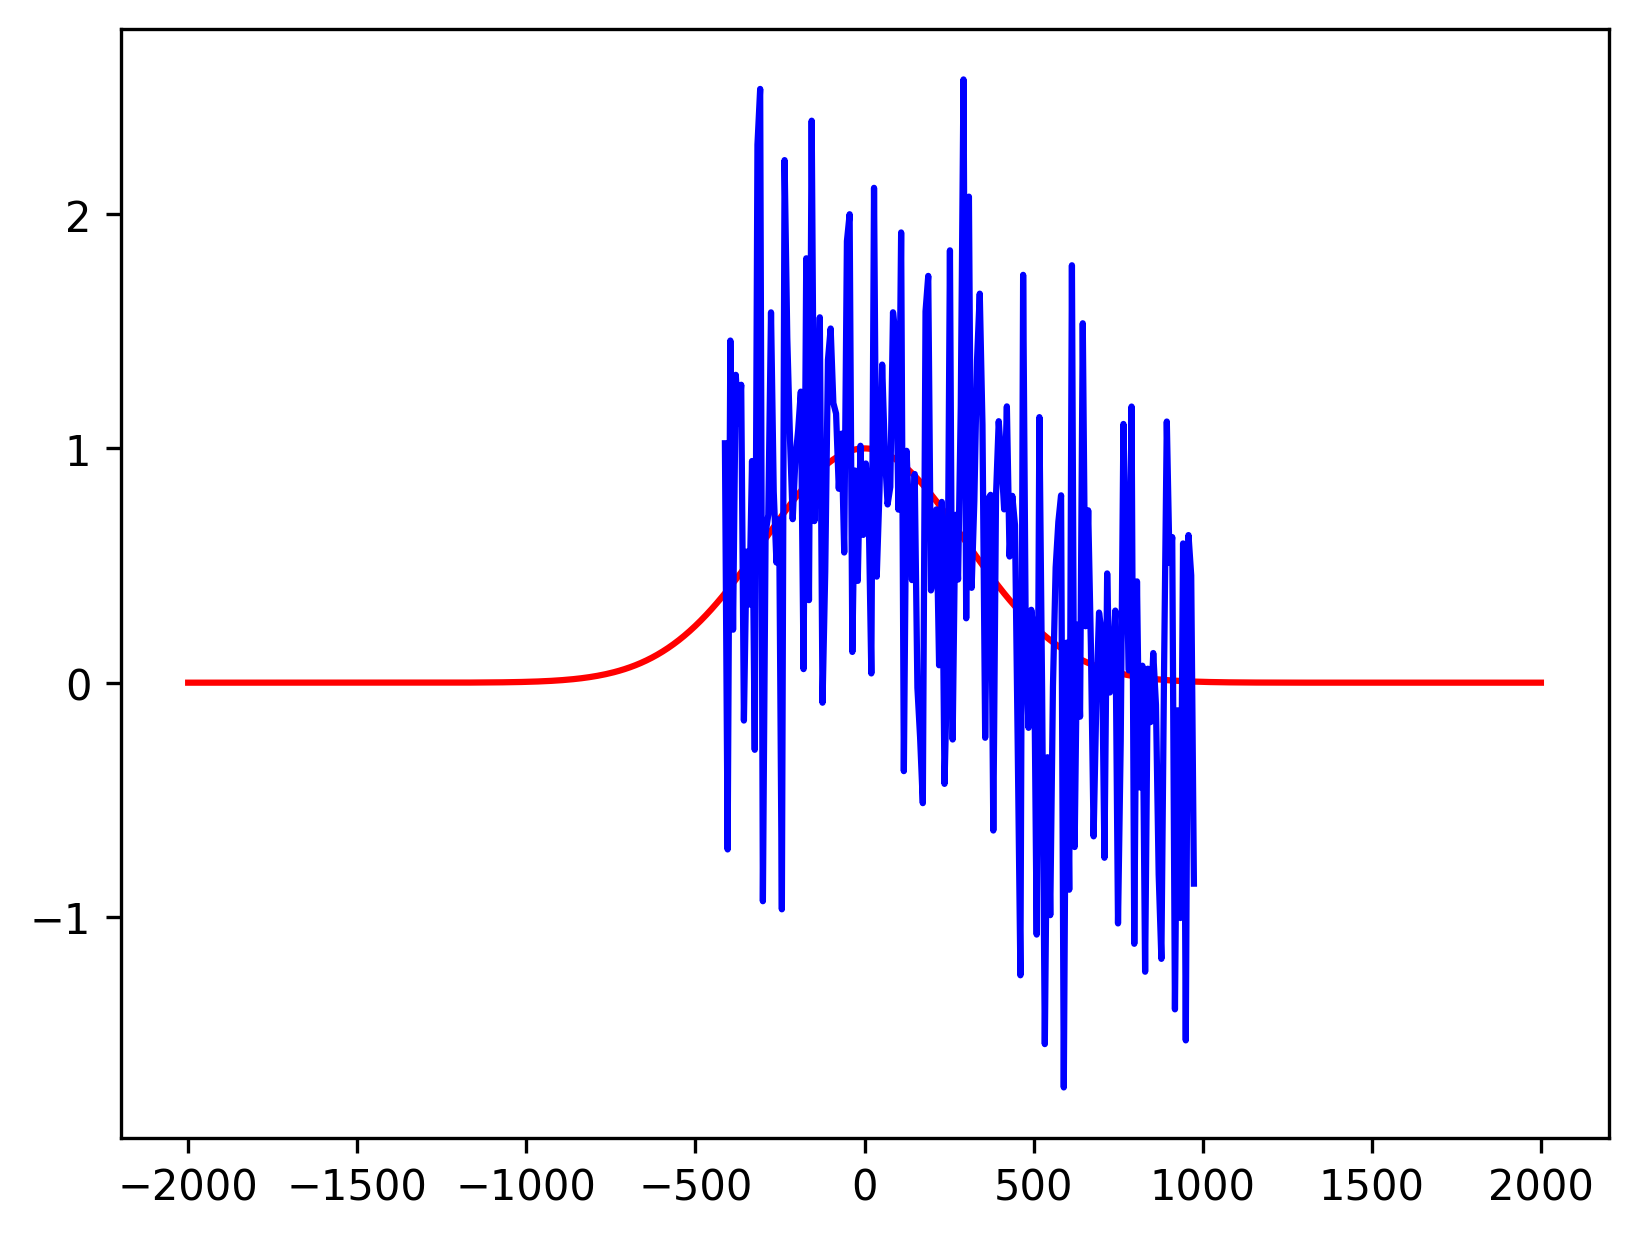

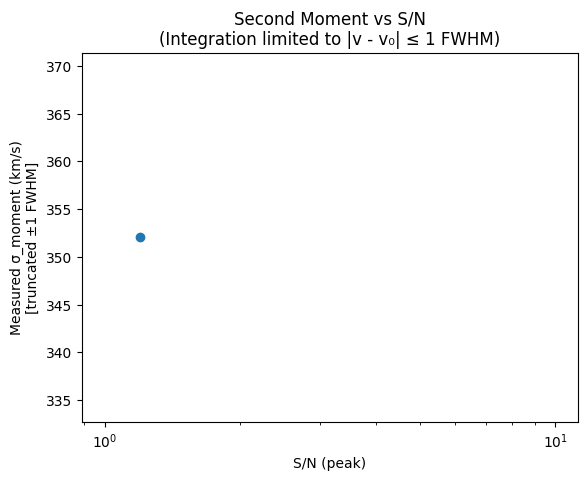

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the true Gaussian
fwhm = 700.0  # km/s
sigma0 = fwhm / 2.355  # conversion to sigma
v = np.linspace(-2000, 2000, 500)  # velocity axis

# True Gaussian profile (amplitude = 1)
true_gauss = np.exp(-0.5 * (v / sigma0) ** 2)

# S/N values to test
snr_values = [1.2]
n_realizations = 1  # Monte Carlo realizations per S/N

measured_sigmas_trunc = []
sigma_errors_trunc = []
plt.figure(dpi=300)
plt.plot(v,true_gauss,"r-",label="True Gaussian")

for snr in snr_values:
    sigs = []
    noise_sigma = 1.0 / snr  # noise rms
    for _ in range(n_realizations):
        noisy_spec = true_gauss + np.random.normal(0, noise_sigma, v.shape)
        # Compute centroid
        centroid = np.sum(v * noisy_spec) / np.sum(noisy_spec)
        # Truncate outside ±1 FWHM region (~±2.355σ)
        mask = np.abs(v - centroid) <= fwhm
        denom = np.sum(noisy_spec[mask])
        if denom <= 0:
            continue
        numerator = np.sum((v[mask] - centroid) ** 2 * noisy_spec[mask])
        sigma_trunc = np.sqrt(numerator / denom)
        sigs.append(sigma_trunc)
        plt.plot(v[mask],noisy_spec[mask],color="blue")
    measured_sigmas_trunc.append(np.mean(sigs))
    sigma_errors_trunc.append(np.std(sigs))

# Plotting
plt.figure()
plt.errorbar(snr_values, measured_sigmas_trunc, yerr=sigma_errors_trunc, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('S/N (peak)')
plt.ylabel('Measured σ_moment (km/s)\n[truncated ±1 FWHM]')
plt.title('Second Moment vs S/N\n(Integration limited to |v - v₀| ≤ 1 FWHM)')
plt.show()


In [214]:
fits.open(KBSSpath+"/Q0207/BX160/spec_1D_par_lris.fits")[1].data[""]


FITS_rec([(1548.195, 'CIV', 1000., 3300., 'CIV1548_br', 2, 1., 0., 1.e+10, 5.e-03, 2.3e-07, 0.0169, -0.01, 0.01, 0, 0, 0, 0.05, 1),
          (1548.195, 'CIV', 1000., 3300., 'CIV1548', 1, 1., 0., 1.e+01, 1.e-06, 2.3e-07, 0.0169, -0.01, 0.01, 6, 6, 0, 0.05, 1),
          (1550.774, 'CIV', 1000., 3300., 'CIV1550', 1, 1., 0., 1.e+01, 1.e-06, 2.3e-07, 0.0169, -0.01, 0.01, 6, 6, 0, 0.05, 1)],
         dtype=(numpy.record, [('lambda', '>f4'), ('compname', 'S20'), ('minwav', '>f4'), ('maxwav', '>f4'), ('linename', 'S20'), ('ngauss', '>i4'), ('inisca', '>f4'), ('minsca', '>f4'), ('maxsca', '>f4'), ('inisig', '>f4'), ('minsig', '>f4'), ('maxsig', '>f4'), ('minvoff', '>f4'), ('maxvoff', '>f4'), ('vindex', '>i4'), ('windex', '>i4'), ('findex', '>i4'), ('fvalue', '>f4'), ('vary', '>i4')]))

In [267]:
fits.open(KBSSpath+"/Q1700/MD157/kcwi_1D/Q1700-MD157_pyqsofit.fits")[1].data["CIV_whole_br_fwhm_err"]#*3e5*2.355



array([1054.96843371], dtype='>f8')

In [217]:
fits.open(KBSSpath+"/Q0100/BX160/lris/Q0100-BX160_pyqsofit.fits")[1].data["CIV_whole_br_fwhm_err"]

array([585.20102903], dtype='>f8')